# 08_ZTM_PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

Paper: https://arxiv.org/abs/2010.11929

## 0. Get setup

Let's import code we've previously written and required libraries.

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.30 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup the device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data

The whole goal of what we're trying to do is replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data:

Namely, the pizza, steak and sushi images we've been using so far.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## 2. Create Datasets and DataLoaders


In [ ]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# CReate image size
IMG_SIZE = 224 # comes from table 3 of ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms:{manual_transforms}")

Manually created transforms:Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our cpu)
BATCH_SIZE = 32

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize!*

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([])


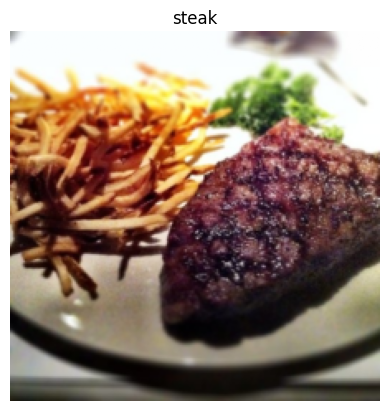

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# Check the image shapes
print(f"Image shape: {image.shape}")
print(f'Label shape: {label.shape}')

# Plot the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [ ]:
label.shape

torch.Size([])

## 3. Replicating ViT:Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces:
* **Inputs**: What goes into the model? (in our case, image tensors)
* **Outputs**: What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers**: Takes an input, manipulates it with a function (for example could be self-attention)
* **Blocks**: A collection of layers.
* **Model**: A collection of blocks

### 3.1 ViT Overciew: Pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: Math equations which define the functions of each layer/block
* Table: 1/3: different hyperparameters for the architecture/training.
* Text

\
### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-figure-1-architecture-overview.png)

* **Embedding:** learnable representation (start with random numbers and improve over time).

\

### Section 3.1

3.1 Vision Transporamer (Vit)

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a ID sequence of token embeddings. To handle 2D imases, we reshape the image $\mathrm{x} \in \mathbb{R}^{N \times W \times C}$ into a sequence of flattened 2D patches $\mathrm{x}_{p} \in \mathbb{R}^{N \times\left(\mu^{2}, C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latem vector size $D$ through all of its layers, so we fatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {clas }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{x}_{2}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $z_{1}^{0}$. The classification bead is implemented by a ML.P with one hidden layer at pretraining time and by a single linear layer at fine-tuning time.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

The Transformer encoder (Vaswani et al, 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and ML.P blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

\

### Four equations

![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-four-equations.png)


### Table 1

![](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-table-1.png)

### 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of **layers**.

And a collection of layers is often referred to as a **block**.

And stacking many blocks together is what gives us the whole architecture.

A **layer** takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's `forward()` method) and then returns an output.

So if a **single layer** takes an input and gives an output, then a collection of layers or a **block** also takes an input and gives an output.

Let's make this concrete:
* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

*A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (for example, the self-attention formula pictured above, however, this function could be almost anything) and then output it. Blocks are generally stacks of layers on top of each other doing a similar thing to a single layer but multiple times.*

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast.

> **Note:** We're going to be focused on writing PyTorch code to create these layers. For the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.